### Используемые сторонние библотеки

* keras (2.4.3)
* matplotlib (3.2.1)
* tensorflow (2.2.0)
* pandas (1.0.3)
* sklearn (0.22.1)
* numpy (1.18.1)

In [1]:
# игнорируем warnings, чтобы не захламлять вывод
import warnings
warnings.filterwarnings("ignore")


In [10]:
# импортируем зависимости
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, Dropout, Dense
import keras
import matplotlib.pyplot as plt
from math import sqrt
plt.style.use('ggplot')
from numpy import array
import pandas as pd
import numpy as np



In [3]:
# функции, связанные с предобработкой

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Создает массив возможных кусков из временного ряда, 
    таких что они включают n_in элементов как обучающую часть, 
    и n_out как предсказываемую. По сути устраняет "краевые эфекты"
    Метод взят из интернета.
    """
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def difference(dataset, interval=1):
    
    """
    Считает разницу между элементами временного ряда,
    отстоящими друг от друга на interval
    """
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def prepare_data(series, n_test, n_lag, n_seq):
    
    """
    Преобразует данные с помощью нахождения разности (тк данные имеют четкий тренд) и шкалирования,
    формирует тренировочную и обучающую части выборки
    """
    
    raw_values = series.values
    
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)

    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [38]:
# функция построения сети

def fit_lstm(
    train, 
    n_lag, 
    n_seq, 
    nb_epoch, 
    n_neurons, 
    learning_rate, 
    validation_size, 
    n_batch=1):
    
    """
    Создает и обучает нейросеть с учетом выбранных параметров.
    Возвращает саму модель и историю изменения метрик loss и val_loss в процессе обучения.
    """
    
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    history = []
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    #model.add(Conv1D(32, kernel_size=3))
    
    model.add(LSTM(
        n_neurons, 
        batch_input_shape=(n_batch, X.shape[1], X.shape[2]), 
        stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='tanh'))
    
    
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae'])
    
        
    history = model.fit(
        X, y, 
        epochs=n_epochs, 
        batch_size=n_batch, 
        validation_split=validation_size, 
        verbose=2, 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=16, min_delta=1e-4,restore_best_weights=True)]
    )

    return model, history.history

In [39]:
# функции, выполняющие прогноз

def forecast_lstm(model, X, n_batch):
    
    """
    Предсказание предстоящих значений после заданной точки
    """
    
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]


def make_forecasts(model, test, n_lag, n_seq, n_batch=1):
    """
    Делает предсказания с помощью переданной модели
    для всех временных участков из test
    """
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts


def inverse_difference(last_ob, forecast):
    """
    Перевод значений из разности к абсолютным 
    """
    
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted


def inverse_transform(series, forecasts, scaler, n_test):
    
    """
    Обратное преобразование данных (после шкалирования и взятия разности)
    """
    
    inverted = list()
    for i in range(len(forecasts)):
        
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        
        inverted.append(inv_diff)
    return inverted

In [40]:
# функции для численной и визуальной оценки качества модели

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    
    """
    Расчет и вывод метрики RMSE для каждой удаленности предсказания
    """
    
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

def plot_forecasts(series, forecasts, n_test):
    
    """
    Отрисовка графика предсказаний из каждой точки тестовой выборки
    График полный (Включает весь train sample).
    """
    
    plt.figure(figsize=(14,7))
    
    plt.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='green')
        
    
    plt.title('Forecasts Plot')
    plt.xlabel('Time point')
    plt.ylabel('log value')
        
    plt.show()
    
def plot_forecasts_cropped(series, forecasts, n_test):
    
    """
    Отрисовка графика предсказаний из каждой точки тестовой выборки
    График обрезанный для лучшей читаемости
    (Включает небольшую часть train sample).
    """
    
    
    plt.figure(figsize=(14,7))
    
    plt.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='green')
        
    plt.xlim([len(series) - 2*n_test, len(series)])
    plt.ylim(
        [min(series[-2*n_test:]), max(series[-2*n_test:])]
    )
    
    plt.title('Forecasts Plot')
    plt.xlabel('Time point')
    plt.ylabel('log value')
    plt.show()

In [45]:
# Все параметры

n_lag = 30 # длина фрагмента временного ряда, используемая для предсказания
n_seq = 3 # количество временных точек, для которых будет строиться предсказание
n_test = 100 # абсолютный размер тестовой выборки
validation_size=0.1 # относительный размер валидационной выборки из трейна
n_epochs = 1000 # число эпох обучения
n_neurons = 64 # число LSTM нейронов
learning_rate = 1e-5 # как быстро двигаемся по весам в процессе оптимизации
LOG = True # будем ли логарифимировать



# читаем табличку, вытаскиваем данные импорта США как удобный вариант для обучения
dataframe = pd.read_csv('MBSComtrade.csv')
dataframe['period_in_date'] = pd.to_datetime(dataframe['period_in_date'])
test_c = 'Russian Federation'
country_subset = dataframe[dataframe.country_english_name == test_c]

country_import = country_subset[country_subset.trade_flow_desc == 'Imports']
country_export = country_subset[country_subset.trade_flow_desc == 'Exports']

series = country_import.value


# если надо, логарифмируем
if LOG == True:

    for i in series.index:
        series[i] = np.log(series[i])


# готовим данные
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

# строим модель
model, history = fit_lstm(
    train, 
    n_lag, 
    n_seq, 
    n_epochs, 
    n_neurons, 
    learning_rate,
    validation_size
)

Epoch 1/1000
189/189 - 0s - loss: 1.1717 - accuracy: 0.2804 - mae: 0.7400 - val_loss: 1.1158 - val_accuracy: 0.2381 - val_mae: 0.6664
Epoch 2/1000
189/189 - 0s - loss: 1.1891 - accuracy: 0.2698 - mae: 0.7407 - val_loss: 1.1280 - val_accuracy: 0.2857 - val_mae: 0.6872
Epoch 3/1000
189/189 - 0s - loss: 1.1573 - accuracy: 0.3333 - mae: 0.7178 - val_loss: 1.0922 - val_accuracy: 0.2857 - val_mae: 0.6514
Epoch 4/1000
189/189 - 0s - loss: 1.1658 - accuracy: 0.2698 - mae: 0.7334 - val_loss: 1.0923 - val_accuracy: 0.2857 - val_mae: 0.6587
Epoch 5/1000
189/189 - 0s - loss: 1.1716 - accuracy: 0.3280 - mae: 0.7254 - val_loss: 1.0820 - val_accuracy: 0.3333 - val_mae: 0.6532
Epoch 6/1000
189/189 - 0s - loss: 1.1320 - accuracy: 0.2910 - mae: 0.7167 - val_loss: 1.0768 - val_accuracy: 0.3810 - val_mae: 0.6521
Epoch 7/1000
189/189 - 0s - loss: 1.1494 - accuracy: 0.3545 - mae: 0.7197 - val_loss: 1.0612 - val_accuracy: 0.3810 - val_mae: 0.6374
Epoch 8/1000
189/189 - 0s - loss: 1.1265 - accuracy: 0.3439 - 

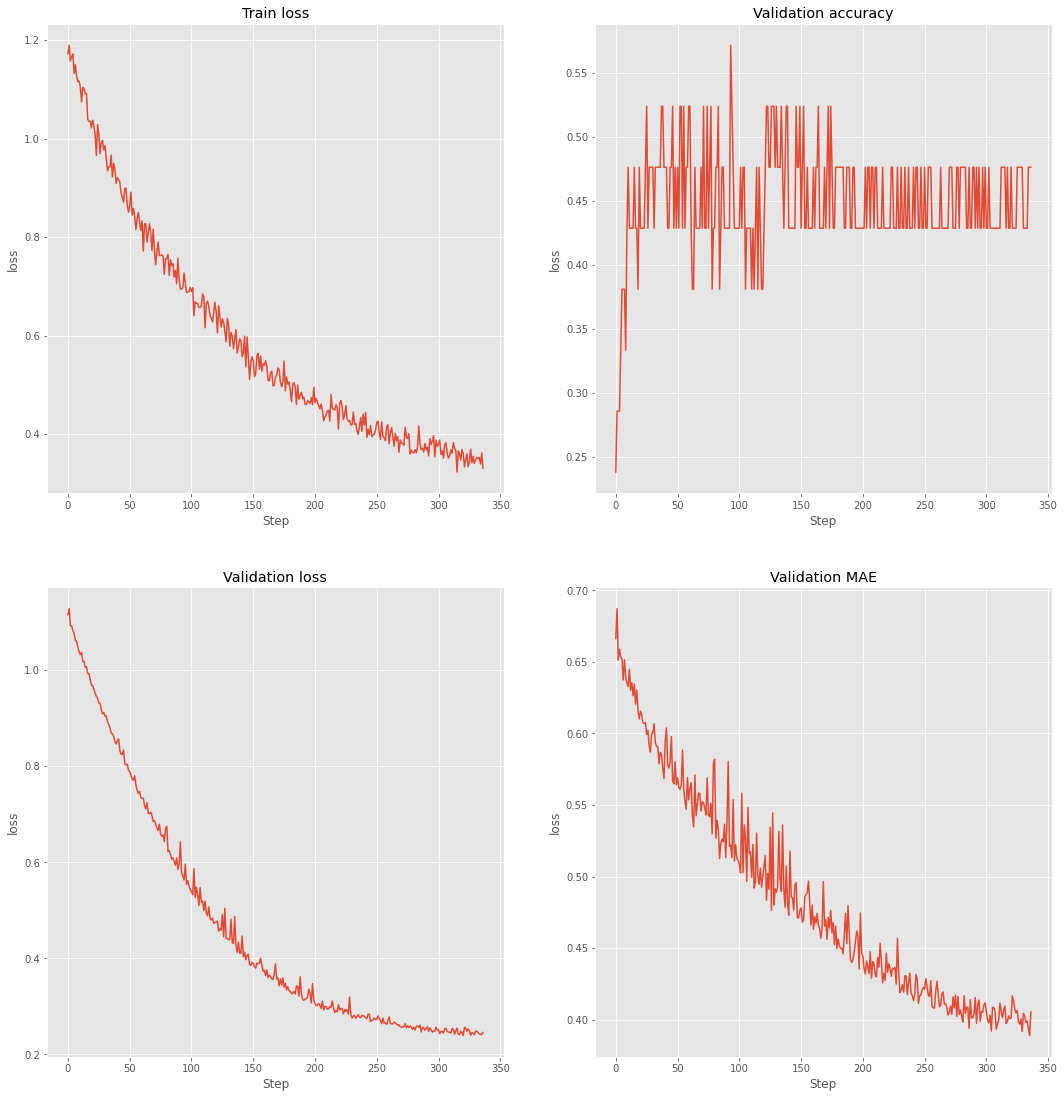

t+1 RMSE: 0.078120
t+2 RMSE: 0.098088
t+3 RMSE: 0.111813


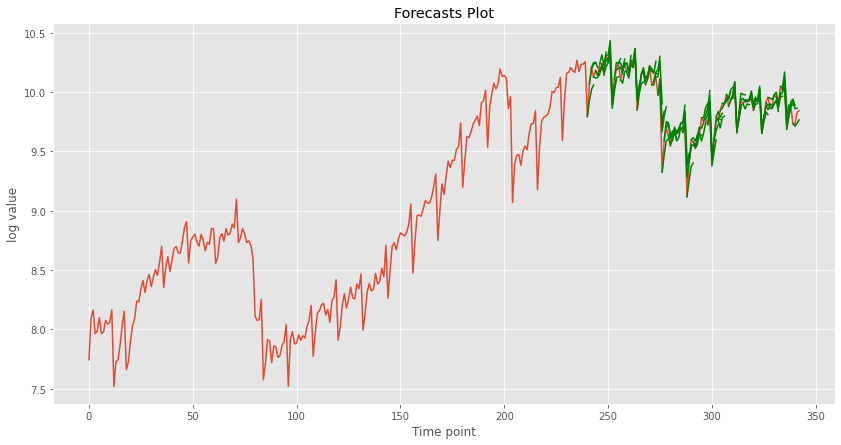

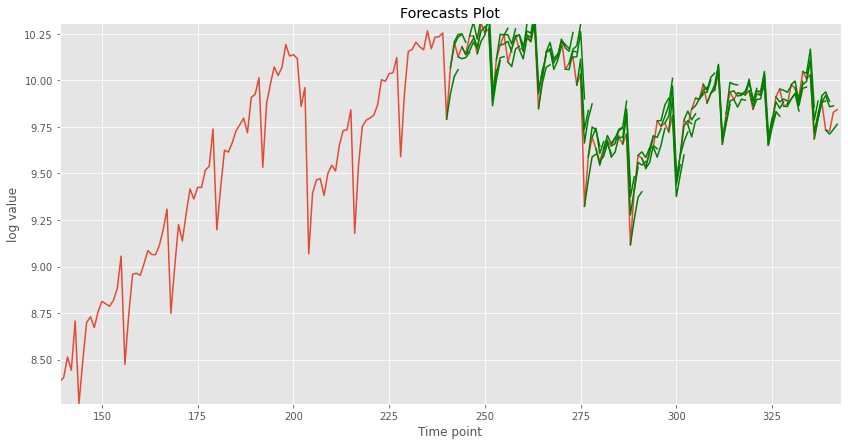

In [46]:
#рисуем метрики
fig, axs = plt.subplots(2,2, figsize=(18,19))
axs[0][0].plot(history['loss'])
axs[0][0].set_title('Train loss')
axs[0][0].set_xlabel('Step')
axs[0][0].set_ylabel('loss')

axs[1][0].plot(history['val_loss'])
axs[1][0].set_title('Validation loss')
axs[1][0].set_xlabel('Step')
axs[1][0].set_ylabel('loss')

axs[0][1].plot(history['val_accuracy'])
axs[0][1].set_title('Validation accuracy')
axs[0][1].set_xlabel('Step')
axs[0][1].set_ylabel('loss')

axs[1][1].plot(history['val_mae'])
axs[1][1].set_title('Validation MAE')
axs[1][1].set_xlabel('Step')
axs[1][1].set_ylabel('loss')

plt.show()



# строим предсказания
forecasts = make_forecasts(model, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)


# вытаскиваем реальные сценарии
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

# на них считаем метрики RMSE
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# рисуем
plot_forecasts(series, forecasts, n_test+2)
plot_forecasts_cropped(series, forecasts, n_test+2)

In [47]:
from scipy.stats import spearmanr

spearmanr(country_export.value, country_import.value)

SpearmanrResult(correlation=0.9234090781524341, pvalue=7.179252601114145e-144)

In [56]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (1, 64)                   24320     
_________________________________________________________________
dropout_11 (Dropout)         (1, 64)                   0         
_________________________________________________________________
dense_22 (Dense)             (1, 64)                   4160      
_________________________________________________________________
dense_23 (Dense)             (1, 3)                    195       
Total params: 28,675
Trainable params: 28,675
Non-trainable params: 0
_________________________________________________________________


In [51]:
oil_df = pd.read_csv('Нефть.WTI.Mounth.csv')

pd.to_datetime(oil_df['Дата'])

ParserError: Unknown string format: Нояб. '20